# English To Hindi Translation Model

The aim is to develop a translation model based on an encoder-decoder model architecture using LSTMs. The dataset used is the IIT Bombay English to Hindi translation dataset. 

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install contractions

   ---------------------------------------- 0.0/289.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/289.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/289.9 kB 660.6 kB/s eta 0:00:01
   -------- ------------------------------ 61.4/289.9 kB 544.7 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/289.9 kB 731.4 kB/s eta 0:00:01
   ------------------ ------------------- 143.4/289.9 kB 711.9 kB/s eta 0:00:01
   ------------------------- ------------ 194.6/289.9 kB 787.7 kB/s eta 0:00:01
   ----------------------------- -------- 225.3/289.9 kB 811.5 kB/s eta 0:00:01
   -------------------------------------  286.7/289.9 kB 886.2 kB/s eta 0:00:01
   -------------------------------------- 289.9/289.9 kB 852.7 kB/s eta 0:00:00


In [5]:
!pip install wordcloud

   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   -------- ------------------------------- 61.4/300.2 kB 1.1 MB/s eta 0:00:01
   -------------------------------- ------- 245.8/300.2 kB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 2.3 MB/s eta 0:00:00


In [7]:
!pip install spacy

   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB 991.0 kB/s eta 0:00:13
   ---------------------------------------- 0.1/12.1 MB 1.1 MB/s eta 0:00:12
   ---------------------------------------- 0.1/12.1 MB 871.5 kB/s eta 0:00:14
    --------------------------------------- 0.2/12.1 MB 926.0 kB/s eta 0:00:13
    --------------------------------------- 0.2/12.1 MB 935.2 kB/s eta 0:00:13
    --------------------------------------- 0.3/12.1 MB 911.0 kB/s eta 0:00:13
    --------------------------------------- 0.3/12.1 MB 983.9 kB/s eta 0:00:12
    --------------------------------------- 0.3/12.1 MB 983.9 kB/s eta 0:00:12
    --------------------------------------- 0.3/12.1 MB 983.9 kB/s eta 0:00:12
    --------------------------------------- 0.3/12.1 MB 983.9 kB/s eta 0:00:12
    --------------------------------------- 0.3/12.1 MB 983.9 kB/s eta 0:00:12
    --------------------------------------- 0.3/12.1 MB 983.9 k

In [2]:
import re
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import indian
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unicodedata
from keras.models import Sequential,Model
from keras.layers import Input,Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
import spacy
import contractions
from nltk.corpus import stopwords
import numpy as np
import pandas as pd 

### Importing dataset

In [3]:
data = pd.read_csv("newdata.csv")

In [4]:
data.head()

,english,hindi
0,"On the other hand , it has been observed that ...",इसके विपरीत देखा यह गया है कि उपयुक़्त आयु में...
1,Now we may find that there are places that are...,अब यह भी हो सकता है कि हमें ऐसे स्थान मिलें जो...
2,He has never told a lie.,उसने कभी झूठ नही बोला है.
3,I can tell you it's a magnificent spread.,मैं आप को बता सकता हूँ कि वो बहुत ही भव्य है॰
4,And one of them came to me the next morning an...,"और उनमें से एक मेरे पास अगली सुबह आया और बोला,"


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210 entries, 0 to 1209
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   english   1210 non-null   object
 1   hindi     1206 non-null   object
dtypes: object(2)
memory usage: 19.0+ KB


In [6]:
data.describe()

,english,hindi
count,1210,1206
unique,1199,1194
top,(Laughter),(हंसी)
freq,7,4


### Data Preprocessing 

In [7]:
data.isnull().sum()

english     0
hindi       4
dtype: int64

In [8]:
data.dropna(inplace = True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1206 entries, 0 to 1209
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   english   1206 non-null   object
 1   hindi     1206 non-null   object
dtypes: object(2)
memory usage: 28.3+ KB


In [10]:
data.sample(10)

,english,hindi
914,Here's the key question.,यही मुख्य सवाल है।
315,But I think our generation also might be the f...,मगर मैं समझता हूँ कि हमारी पीढी ने ही शायद पहल...
1070,Wisconsin,विस्कान्सिन
639,Unheard facts about Bhaghat Singh(Sunday),भगत सिंह के बारे में कुछ अनदेखे तथ्य (रविवार)
240,after that they have do 3 year course in chose...,इसके भाद उन्हें सामान्यतया एक ३-वर्षीय स्नातक ...
286,"A couple of years ago,","दो वर्ष पहले,"
944,Because I tried to make it intimate.,मैं उसे ये तोह्फा बड़े प्यार से देना चाहता था.
410,YouTube relies on its users to flag the conten...,अपलॊड करने वाला यूट्यूब कॊ अपॊड की हुइ सामग्री...
901,At the moment though every anti-Americanist is...,"वैसे , अमेरिकीपन का हर विरोधी ऐसा नहीं कर रहा ..."
405,"If there is a warranty , what does it include ...","अगर वारंटी है , तो उसमें क्या शामिल है ह्यऔर क..."


In [11]:
#now we need to preprocess the text ---> remove punctuations, contractions, html tags, urls etc. 

In [12]:
#remove html tags 

In [11]:
def remove_html(text):
    if isinstance(text,str):
        pattern = re.compile('<.*?>')
        return pattern.sub(r'',text)
    else:
        return text

In [12]:
# remove url

In [13]:
def remove_url(text):
    if isinstance(text,str):
        pattern = re.compile(r'https?://\S+|www\.\S+')
        return pattern.sub(r'',text)
    else:
        return

In [14]:
# remove alphanumeric characters

In [15]:
def preprocess_text(text, language='english'):
    if not isinstance(text, str):
        return text
    if language == 'english':
        pattern = re.compile(r'[^a-zA-Z0-9\s]')
        return pattern.sub(r'', text)
    elif language == 'hindi':
        pattern = re.compile(r'[^\u0900-\u097F\s]')
        return pattern.sub(r'', text)
    else:
        raise ValueError("Unsupported Language, Supported languages are 'english' and 'hindi'")

In [16]:
data.rename(columns = {'english ' : 'english'}, inplace = True)

In [17]:
data.columns

Index(['english', 'hindi'], dtype='object')

In [18]:
data['english'] = data['english'].apply(remove_html)

In [19]:
data["hindi"] = data["hindi"].apply(remove_html)

In [20]:
data['english'] = data['english'].apply(remove_url)
data["hindi"] = data["hindi"].apply(remove_url)

In [21]:
data['english'] = data['english'].apply(lambda x: preprocess_text(x, language='english'))
data['hindi'] = data['hindi'].apply(lambda x: preprocess_text(x, language='hindi'))

In [22]:
# at this stage we don't have any html tags, url tags and alphanumeric characters

In [23]:
#now we need to remove punctuations before tokenising the texts 

In [24]:
#English punctuations

In [25]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
def get_hindi_punctuations():
    hindi_punctuations = []
    for i in range(0x2000, 0x206f + 1):
        char = chr(i)
        if unicodedata.category(char) == 'Po':
            hindi_punctuations.append(char)
    return ''.join(hindi_punctuations)

In [27]:
hindi_punctuation = get_hindi_punctuations()

In [28]:
hindi_punctuation

'‖‗†‡•‣․‥…‧‰‱′″‴‵‶‷‸※‼‽‾⁁⁂⁃⁇⁈⁉⁊⁋⁌⁍⁎⁏⁐⁑⁓⁕⁖⁗⁘⁙⁚⁛⁜⁝⁞'

In [29]:
def remove_punctuation(text, language = 'english'):
    if language == 'english':
        exclude_english = set(string.punctuation)
        return ''.join(char for char in text if char not in exclude_english)
    elif language == 'hindi':
        return ''.join(char for char in text if char not in hindi_punctuation)
    
    else:
        raise ValueError("Unsupported Language, Supported languages are 'english' and 'hindi'")

In [30]:
data['english'] = data['english'].apply(lambda x: remove_punctuation(x,language = 'english'))
data['hindi'] = data['hindi'].apply(lambda x: remove_punctuation(x,language = 'hindi'))

In [31]:
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

In [32]:
data["english"] = data["english"].apply(expand_contractions)

In [33]:
# data is now clean and ready to be tokenised

In [34]:
def do_tokenization(text):
    token_words = word_tokenize(text)
    return token_words

In [35]:
data["english"] = data["english"].apply(do_tokenization)
data["hindi"] = data["hindi"].apply(do_tokenization)

In [36]:
data['english'][500]

['Hindi', 'Poet']

In [37]:
data["hindi"][500]

['हिन्दी', 'कवि']

In [38]:
# now amongst these we need to remove the stop words

In [39]:
len(stopwords.words("english"))

179

In [40]:
nltk.download("indian")

[nltk_data] Downloading package indian to C:\Users\Diya
[nltk_data]     Sivaprasad\AppData\Roaming\nltk_data...
[nltk_data]   Package indian is already up-to-date!


True

In [41]:
len(nltk.corpus.indian.words('hindi.pos'))

9408

In [42]:
# collecting the stopwords

In [43]:
stop_words_english = set(stopwords.words('english'))
stop_words_hindi = set(nltk.corpus.indian.words('hindi.pos'))

In [44]:
# function to remove stopwords

In [45]:
def remove_stopwords(text,language = 'english'):
    if language == 'english':
        filtered_words_english = [word for word in text if word.lower() not in stop_words_english]
        return ' '.join(filtered_words_english)
    elif language == 'hindi':
        filterd_words_hindi = [word for word in text if word not in stop_words_hindi]
        return ' '.join(filterd_words_hindi)
    else:
        return ValueError("Unsupported Language, Supported languages are 'english' and 'hindi'")

In [46]:
data['english'] = data['english'].apply(lambda x :remove_stopwords(x,language = 'english'))
data['hindi'] = data['hindi'].apply(lambda x :remove_stopwords(x,language = 'hindi'))

In [47]:
data.sample(5)

,english,hindi
194,Data relating parliamentary activities contain...,प्रणाली डैटाबेस सम्मिलित संसदीय कार्यकलापों आध...
1208,women ages 20 64 entitled free smear test chec...,नैशनल सरवाकिल कार्यऋम महिलाएऋ ऋनकी आयु मुफ्त स...
752,took prison governor,जेल तरह
803,Valmiki Ramayana Publisher Dehati Pustak Bhand...,वाल्मीकीय रामायण प्रकाशक देहाती भंडार
641,Traders often belong trade associations,व्यापारी अक्सर ट्रेड व्यापारी मंडलों


In [48]:
# now we need to convert words into their root forms ---> via the process of stemming

In [49]:
def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    return [ps.stem(word) for word in words]

In [50]:
data["english"] = data["english"].apply(stemming)
data["hindi"] = data["hindi"].apply(stemming)

In [51]:
data.sample(5)

,english,hindi
831,"[relat, part]",[कड़ियाँ]
110,[context],[संदर्भ]
728,"[rememb, benefit, gp, good, night, sleep, call...","[याद, रखें, आपको, जभी, लाभ, आपके, जीपी, रातभर,..."
37,"[typic, second, best, guess, third, best, gues...","[आमतौर, पूर्वानुमान, जवाब, था।]"
408,"[feel, love, bind, us]","[एकदूसरे, जोड़नेवाला, प्रेम]"


In [52]:
# we are done with the data pre-processing 

### Tokenisation

In [53]:
tokenizer_english = Tokenizer()

In [54]:
tokenizer_english.fit_on_texts(data["english"])

In [55]:
tokenizer_hindi = Tokenizer()

In [56]:
tokenizer_hindi.fit_on_texts(data["hindi"])

In [57]:
tokenizer_hindi.word_index['<start>'] = len(tokenizer_hindi.word_index) + 1
tokenizer_hindi.word_index['<end>'] = len(tokenizer_hindi.word_index) + 1

In [58]:
def add_special_tokens(sequences, start_token='<start>', end_token='<end>'):
    sequences_with_special_tokens = []
    for sequence in sequences:
        sequence_with_special_tokens = [start_token] + sequence + [end_token]
        sequences_with_special_tokens.append(sequence_with_special_tokens)
    return sequences_with_special_tokens

In [59]:
data['hindi'] = add_special_tokens(data['hindi'])

In [60]:
data.sample(10)

,english,hindi
1040,"[whole, detail, go, happen, polit, scene]","[<start>, यंहा, <end>]"
772,"[left, unknown, destin, abroad]","[<start>, अज्ञात, चुपचाप, प्रस्थान, करा, <end>]"
1161,"[south, korea, 185]","[<start>, कोरिया, १८५, <end>]"
442,[upset],"[<start>, तुम, जाओगी, <end>]"
717,[music],"[<start>, <end>]"
481,"[directli, approach, princip, scottish, church...","[<start>, सीधे, स्काटिश, चर्च, कालेज, प्रिंसिप..."
412,"[meanwhil, 15, januari, north, india, rock, ea...","[<start>, उत्तरी, जनपदों, संपत्ति, क्षति, <end>]"
827,"[accord, historian, viewpointdur, end, civilis...","[<start>, इतिहासकारों, दृष्टिकोण, सभ्यता, अन्त..."
319,"[civil, societi, leader]","[<start>, सामजिक, लगायें, <end>]"
1005,[laughter],"[<start>, ठहाके, <end>]"


In [61]:
data["english"] = tokenizer_english.texts_to_sequences(data["english"])
data["hindi"] = tokenizer_hindi.texts_to_sequences(data["hindi"])

In [62]:
data.sample(10)

,english,hindi
582,"[2854, 301]","[4582, 2929, 2930, 2931, 4583]"
917,"[195, 9, 3476, 3477]","[4582, 82, 3794, 3795, 253, 4583]"
317,"[844, 2296, 4, 1251, 5, 468, 2297, 2298, 12, 8...","[4582, 2135, 2136, 830, 730, 2137, 151, 2138, ..."
925,"[36, 322, 38, 381, 804, 491, 10]","[4582, 506, 5, 3819, 161, 3820, 4583]"
155,"[769, 387, 86, 272, 96, 571, 1106, 572, 1911]","[4582, 82, 386, 1610, 399, 678, 4583]"
1060,"[969, 47, 3722, 104, 47, 3723, 68, 336]","[4582, 1029, 1132, 1132, 4167, 4583]"
707,"[219, 93, 63, 142]","[4582, 392, 40, 1027, 4583]"
656,"[1164, 2987, 2988, 2989, 454, 2990, 2991, 898,...","[4582, 958, 3123, 3124, 3125, 1012, 3126, 4583]"
1198,"[4002, 70, 591, 537, 626, 402, 296, 448]","[4582, 4525, 4526, 4527, 4528, 235, 105, 4583]"
983,"[326, 524, 1462, 216, 211, 1444, 1555, 3589, 3...","[4582, 607, 3960, 3961, 3962, 398, 4583]"


In [63]:
#now we can go ahead with the train and test split part

### Model Training 

In [64]:
x_train, x_test, y_train, y_test = train_test_split(data["english"], data["hindi"], test_size = 0.2, random_state = 42)

In [65]:
print(len(x_train))
print(len(x_test))

964
242


In [66]:
print(len(y_train))
print(len(y_test))

964
242


In [67]:
# now we add padding to the data 

In [68]:
def max_sequence_length(text):
    combined_sequences = text
    max_length_combined = max(len(sequence) for sequence in combined_sequences)
    return max_length_combined

In [69]:
max_length_x = max_sequence_length(data["english"])
max_length_y = max_sequence_length(data["hindi"])

In [70]:
max_length_x

124

In [71]:
max_length_y

92

In [72]:
x_train.shape

(964,)

In [73]:
x_train_new = pad_sequences(x_train, maxlen = max_length_x, padding = 'post')
y_train_new = pad_sequences(y_train, maxlen = max_length_y, padding = 'post')
x_test_new = pad_sequences(x_test, maxlen = max_length_x, padding = 'post')
y_test_new = pad_sequences(y_test, maxlen = max_length_y, padding = 'post')

In [74]:
#establishing the model 

In [89]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention,Activation, Concatenate, TimeDistributed, Dot

In [76]:
from tensorflow.keras.models import Model

In [91]:
def create_model(vocab_size_input, vocab_size_output, max_seq_length_input, max_seq_length_output, embedding_dim, hidden_units):
    ## encoder
    encoder_inputs = Input(shape=(max_seq_length_input,))
    encoder_embedding = Embedding(input_dim=vocab_size_input, output_dim=embedding_dim)(encoder_inputs)
    encoder_lstm, state_h, state_c = LSTM(hidden_units, return_state=True, return_sequences = True)(encoder_embedding)
    encoder_states = [state_h, state_c]
    
    ## decoder
    decoder_inputs = Input(shape=(max_seq_length_output,))
    decoder_embedding = Embedding(input_dim=vocab_size_output, output_dim=embedding_dim)(decoder_inputs)
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
    decoder_lstm_output, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

    ##attention
    attention_dot = Dot(axes=[2, 2])([decoder_lstm_output, encoder_lstm])
    attention_activation = Activation('softmax')(attention_dot)
    context_vector = Dot(axes=[2, 1])([attention_activation, encoder_lstm])
    attention_output = Concatenate(axis=-1)([context_vector, decoder_lstm_output])

    ##output
    decoder_dense = TimeDistributed(Dense(vocab_size_output, activation='softmax'))
    decoder_outputs = decoder_dense(attention_output)
    
    ## model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    print(model.summary())
    return model

In [78]:
vocab_size_input = len(tokenizer_english.word_index) + 1
vocab_size_output = len(tokenizer_hindi.word_index) + 1

In [79]:
vocab_size_output

4584

In [80]:
vocab_size_input

4044

In [81]:
max_seq_length_input = max_length_x
max_seq_length_output = max_length_y - 1

In [82]:
# defining other hyper-parameters

In [83]:
embedding_dim = 100
hidden_units = 256

In [92]:
model = create_model(vocab_size_input, vocab_size_output, max_seq_length_input, max_seq_length_output, embedding_dim, hidden_units)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 124)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 91)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 124, 100)  │    404,400 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 91, 100)   │    458,400 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, 124,      │    365,568 │ embedding_8[0][0] │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 91, 256), │    365,568 │ embedding_9[0][0… │
│                     │ (None, 256),      │            │ lstm_8[0][1],     │
│                     │ (None, 256)]      │            │ lstm_8[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 91, 124)   │          0 │ lstm_9[0][0],     │
│                     │                   │            │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 91, 124)   │          0 │ dot_3[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_4 (Dot)         │ (None, 91, 256)   │          0 │ activation_1[0][… │
│                     │                   │            │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 91, 512)   │          0 │ dot_4[0][0],      │
│ (Concatenate)       │                   │            │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 91, 4584)  │  2,351,592 │ concatenate_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,945,528 (15.05 MB)

 Trainable params: 3,945,528 (15.05 MB)

 Non-trainable params: 0 (0.00 B)

None


In [93]:
#to note that the embedding and the dense layers contribute to the maximum number of parameters

In [94]:
#we have the model now to compile and fit on the data 

In [95]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [96]:
#define callbacks and checkpoints

In [97]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [98]:
callbacks = [
    EarlyStopping(patience = 3, monitor = "val_loss"),
    ModelCheckpoint(filepath='model_weights.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss')
]

In [99]:
batch_size = 60
epochs = 20

In [100]:
len(y_train_new)

964

In [101]:
history = model.fit(x=[x_train_new, y_train_new[:, :-1]],
                    y=y_train_new[:, 1:],  
                    batch_size=batch_size,
                    epochs=10,
                    validation_data=([x_test_new, y_test_new[:, :-1]], y_test_new[:, 1:]),
                    callbacks=callbacks)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7421 - loss: 5.6442 - val_accuracy: 0.9231 - val_loss: 0.7170
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9202 - loss: 0.7183 - val_accuracy: 0.9231 - val_loss: 0.6756
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9208 - loss: 0.6343 - val_accuracy: 0.9232 - val_loss: 0.6709
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9194 - loss: 0.6274 - val_accuracy: 0.9268 - val_loss: 0.6766
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9239 - loss: 0.6054 - val_accuracy: 0.9288 - val_loss: 0.6785
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9273 - loss: 0.5962 - val_accuracy: 0.9328 - val_loss: 0.6807


### Saving Model Weights

In [102]:
weights_file_path = 'model_weights_main.weights.h5'
model.save_weights(weights_file_path)
print("Model weights saved successfully.")

Model weights saved successfully.


### Plotting model accuracy and loss

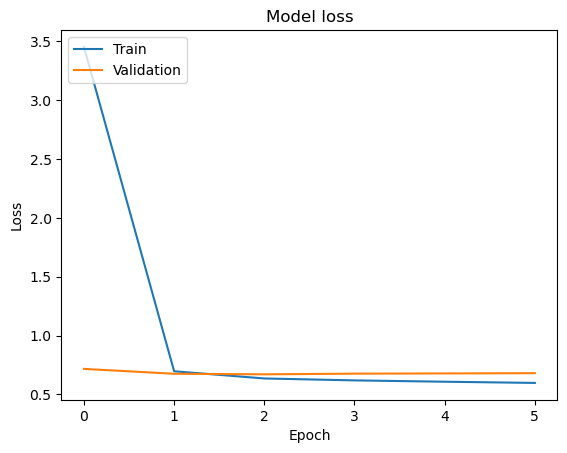

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

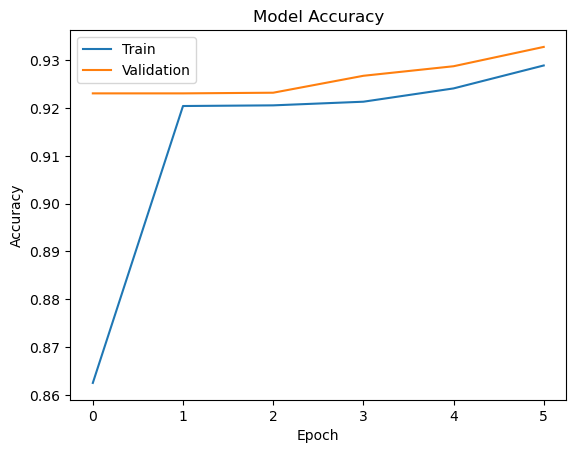

In [104]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [110]:
print("maximum accuracy = ", round(max(history.history['accuracy']),5)*100, "%")

maximum accuracy =  92.891 %


In [106]:
print("maximum validatio"max(history.history['val_accuracy']))

0.9327945709228516